### Author: Ran Meng

This jupyter notebook contains my work for certification of "Customer Segmentation in Python" instructed by Karolis Urbonas of Amazon, from [DataCamp](https://www.datacamp.com/courses/customer-segmentation-in-python)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
online = pd.read_csv('online.csv') #Online Retail dataset with over 500K transactions

In [3]:
online.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


In [4]:
# Parsing the date 
# Define a function that will parse the date
def get_day(x): 
    x = dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    return dt.datetime(x.year, x.month, x.day) 

def get_month(x):
    x = dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    return dt.datetime(x.year, x.month, 1)

# Create InvoiceDay column
online['InvoiceDay'] = online['InvoiceDate'].apply(get_day) 
online['InvoiceMonth'] = online['InvoiceDate'].apply(get_month) 
# Group by CustomerID and select the InvoiceDay value
grouping = online.groupby('CustomerID')

# Assign a minimum InvoiceDay value to the dataset
online['CohortDay'] = grouping['InvoiceDay'] .transform('min')
online['CohortMonth'] = grouping['InvoiceMonth'] .transform('min')

# View the top 5 rows
online.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,InvoiceMonth,CohortDay,CohortMonth
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-25,2011-10-01,2011-04-11,2011-04-01
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-20,2011-11-01,2011-09-12,2011-09-01
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-14,2011-07-01,2011-07-14,2011-07-01
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-23,2011-11-01,2011-11-23,2011-11-01
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-25,2011-05-01,2011-02-25,2011-02-01


In [5]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# Get the integers for date parts from the `InvoiceDay` column
invoice_year, invoice_month, invoice_day = get_date_int(online, 'InvoiceDay')

# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, cohort_day = get_date_int(online, 'CohortDay')

# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Calculate difference in days
days_diff = invoice_day - cohort_day

In [6]:
print(invoice_year[0])
print(invoice_month[0])
print(invoice_day[0])

2011
10
25


In [7]:
# Count the number of unique values per customer ID
online['CohortIndex'] = years_diff * 12 + months_diff + 1
grouping = online.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

# Create a pivot 
cohort_counts = cohort_data.pivot_table(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]
cohort_sizes

CohortMonth
2010-12-01    716.0
2011-01-01    332.0
2011-02-01    316.0
2011-03-01    388.0
2011-04-01    255.0
2011-05-01    249.0
2011-06-01    207.0
2011-07-01    173.0
2011-08-01    139.0
2011-09-01    279.0
2011-10-01    318.0
2011-11-01    291.0
2011-12-01     38.0
Name: 1, dtype: float64

In [8]:
# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.343575,0.308659,0.350559,0.342179,0.398045,0.347765,0.329609,0.335196,0.370112,0.354749,0.486034,0.240223
2011-01-01,1.0,0.207831,0.246988,0.243976,0.331325,0.271084,0.246988,0.259036,0.313253,0.307229,0.373494,0.135542,NaN
2011-02-01,1.0,0.183544,0.180380,0.262658,0.268987,0.234177,0.253165,0.262658,0.272152,0.300633,0.088608,NaN,NaN
2011-03-01,1.0,0.162371,0.257732,0.195876,0.213918,0.172680,0.252577,0.219072,0.275773,0.097938,NaN,NaN,NaN
2011-04-01,1.0,0.192157,0.203922,0.192157,0.184314,0.203922,0.219608,0.231373,0.066667,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.160643,0.172691,0.144578,0.208835,0.232932,0.244980,0.088353,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.159420,0.125604,0.198068,0.236715,0.299517,0.091787,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.161850,0.179191,0.219653,0.254335,0.098266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.215827,0.201439,0.251799,0.100719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = online.groupby(['CohortMonth', 'CohortIndex']) 

# Calculate the average of the unit price column
cohort_data = grouping['UnitPrice'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_quantity = cohort_data.pivot_table(index= 'CohortMonth', columns= 'CohortIndex', values='UnitPrice')
average_quantity.round(1)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,3.0,3.0,3.0,2.8,2.7,6.9,2.8,3.0,2.7,2.7,3.0,2.8,2.6
2011-01-01,3.2,3.1,3.0,3.0,3.1,3.0,3.0,2.5,2.7,2.9,2.6,2.0,NaN
2011-02-01,3.1,4.0,3.3,2.9,3.3,2.9,2.8,2.7,2.9,2.7,3.1,NaN,NaN
2011-03-01,3.5,3.6,3.5,2.8,2.7,2.5,2.7,2.9,2.5,2.4,NaN,NaN,NaN
2011-04-01,3.3,4.4,3.4,2.6,2.8,2.8,2.8,2.6,2.6,NaN,NaN,NaN,NaN
2011-05-01,3.1,2.8,2.5,2.7,2.5,2.3,2.7,2.3,NaN,NaN,NaN,NaN,NaN
2011-06-01,2.8,2.4,2.7,3.1,2.5,2.4,2.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,3.2,3.1,3.4,2.5,2.4,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,2.9,3.7,5.4,6.9,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


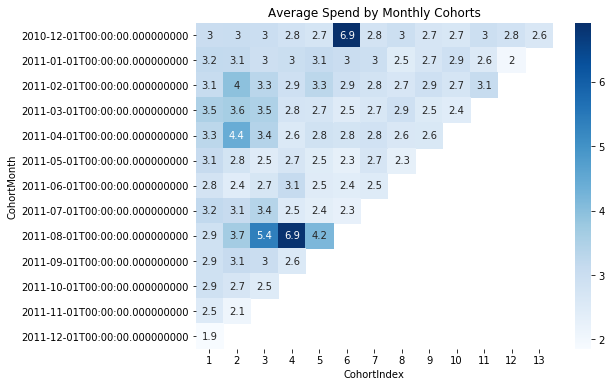

In [10]:
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8,6))

# Add a title
plt.title('Average Spend by Monthly Cohorts')

# Create the heatmap
sns.heatmap(average_quantity, annot= True, cmap='Blues')
plt.show()

## RFM Analysis

In [11]:
# Calculate Recency, Frequency and Monetary value for each customer 
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])
snapshot_date = max(online['InvoiceDate']) + timedelta(days = 1)

online['TotalSum'] = online['UnitPrice'] * online['Quantity']
datamart = online.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count', 
    'TotalSum': 'sum'})
    

# Rename the columns 
datamart.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

# Print top 5 rows
datamart_rfm = datamart
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,27,992.82
12748,1,967,7522.06
12749,4,37,813.45
12820,3,17,268.02
12822,71,9,146.15


### Building RFM Segments

In [12]:
# Create labels for Recency, Frequency and MonetaryValue
r_labels = range(3, 0, -1)
f_labels = range(1, 4)
m_labels = range(1, 4)

# Assign these labels to three equal percentile groups 
r_groups = pd.qcut(datamart['Recency'], q=3, labels=r_labels)

# Assign these labels to three equal percentile groups 
f_groups = pd.qcut(datamart['Frequency'], q=3, labels=f_labels)

# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(datamart['MonetaryValue'], q=3, labels=m_labels)


# Create new columns R,F and M 
datamart = datamart.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)


# Calculate RFM_Score
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1) #Summing across the columns
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score
CustomerID,,,,,,,
12747,2,27,992.82,3,3,3,9.0
12748,1,967,7522.06,3,3,3,9.0
12749,4,37,813.45,3,3,3,9.0
12820,3,17,268.02,3,3,3,9.0
12822,71,9,146.15,2,2,2,6.0


In [13]:
# Define rfm_level function
def rfm_level(df):
    
    if df['RFM_Score'] >= 9:
        return 'Top'
    
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 9)):
        return 'Middle'
    
    else:
        return 'Low'

# Create a new variable RFM_Level
datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)

# Print the header with top 5 rows to the console
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Level
CustomerID,,,,,,,,
12747,2,27,992.82,3,3,3,9.0,Top
12748,1,967,7522.06,3,3,3,9.0,Top
12749,4,37,813.45,3,3,3,9.0,Top
12820,3,17,268.02,3,3,3,9.0,Top
12822,71,9,146.15,2,2,2,6.0,Middle


In [14]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = datamart.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
  
  	# Return the size of each segment
    'MonetaryValue': ['mean', 'count']
}).round(1)

# Print the aggregated dataset
rfm_level_agg

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low         161.5       4.5          86.9  1649
Middle       51.8      18.4         340.1  1486
Top          10.3      63.7        1342.1   566

### Visiualizing RFM Distributions and pre-process data before K-Means clustering

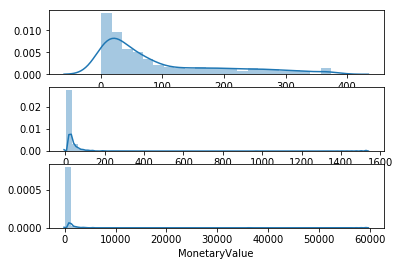

In [15]:
# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(datamart_rfm['Recency'])

# Plot frequency distribution
plt.subplot(3,1,2); sns.distplot(datamart_rfm['Frequency'])

# Plot monetary value distribution
plt.subplot(3,1,3); sns.distplot(datamart_rfm['MonetaryValue'])

# Show the plot
plt.show()

In [16]:
# Unskew the data by applying log transformation
datamart_log = np.log(datamart_rfm)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
datamart_normalized = scaler.transform(datamart_log)

# Create a pandas DataFrame
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)

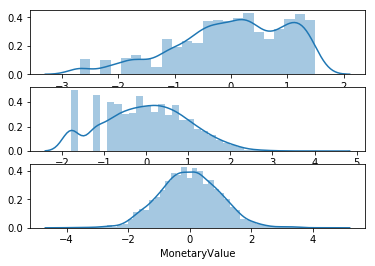

In [17]:
# Plot recency distribution after unskewing the data with log transformation
plt.subplot(3, 1, 1); sns.distplot(datamart_normalized['Recency'])

# Plot frequency distribution after unskewing the data
plt.subplot(3, 1, 2);  sns.distplot(datamart_normalized['Frequency'])

# Plot monetary value distribution after unskewing the data
plt.subplot(3, 1, 3); sns.distplot(datamart_normalized['MonetaryValue'])

# Show the plot
plt.show()

### K Means Clustering

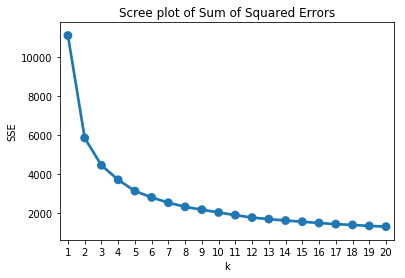

In [18]:
# Import KMeans 
from sklearn.cluster import KMeans

SSE = {}
# Determining the optimal number of clusters by calculating SSE for each k
for k in range(1, 21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters = k, random_state = 1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(datamart_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    SSE[k] = kmeans.inertia_
    

# Add the plot title "The Elbow Method"
plt.title('Scree plot of Sum of Squared Errors')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(SSE.keys()), y=list(SSE.values()))
plt.show()

In [19]:
# Choosing K = 3 for segmentation
# Initialize KMeans
kmeans = KMeans(n_clusters = 3, random_state = 1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

# Create a new DataFrame by adding a cluster label column to datamart_rfm
datamart_k3 = datamart_rfm.assign(Cluster=cluster_labels)

# Group by cluster
grouped = datamart_k3.groupby(['Cluster'])

# Calculate average RFMT values and segment sizes for each cluster
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          78.4      13.6         232.0  1621
1         171.6       3.1          55.3  1225
2          13.8      52.7        1128.1   855

In [20]:
# Melt the normalized dataset and reset the index
datamart_normalized['Cluster'] = datamart_k3['Cluster']

datamart_melt = pd.melt(datamart_normalized.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables
                    id_vars=['CustomerID', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        
# Name the variable and value
                    var_name='Metric', value_name='Value')

datamart_melt.head()

,CustomerID,Cluster,Metric,Value
0,12747,2,Recency,-2.195642
1,12748,2,Recency,-2.684553
2,12749,2,Recency,-1.706731
3,12820,2,Recency,-1.909647
4,12822,0,Recency,0.322128


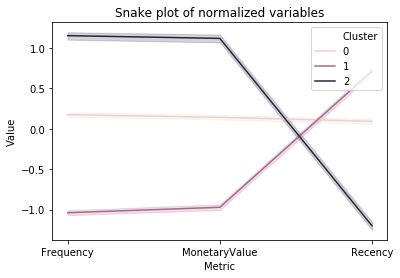

In [21]:
# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data = datamart_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

In [22]:
# Calculate average RFM values for each cluster
cluster_avg = datamart_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = datamart_rfm.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg /population_avg - 1

# Print relative importance scores rounded to 2 decimals. The further away from 0 the more significant
#the attribute is for that segment
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.17,-0.29,-0.39
1,0.82,-0.84,-0.85
2,-0.85,1.75,1.96


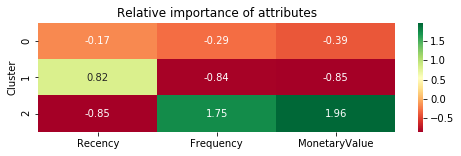

In [23]:
# Plotting heatmap 
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()